In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Prep Data
data_dir = '/content/drive/MyDrive/Colab Notebooks/NSDP_Project/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

img, label = image_datasets['train'][0]
print(img.size())

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=112, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=112, out_channels=56, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=56, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
                nn.Linear(in_features=4*28*28, out_features=784),
                nn.ReLU(),
                nn.Linear(in_features=784, out_features=1)  # Output a single logit for binary classification
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x  # Return logits

model = CNN().to(device)

# Use BCEWithLogitsLoss for binary classification
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Start a timer
start_time = time.time()

loss_list = []
accuracy_list = []

for epoch in range(20):
    epoch_loss = 0
    model.train()  # Set the model to training mode
    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Move images and labels to GPU and reshape labels
        outputs = model(images)
        loss = loss_func(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_list.append(epoch_loss / len(dataloaders['train']))

    # Calculate training accuracy
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloaders['train']:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Move images and labels to GPU and reshape labels
            outputs = model(images)
            predicted = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracy_list.append(accuracy)

    print(f'Epoch {epoch + 1} of 20. Training accuracy: {accuracy} and Loss: {loss_list[-1]}')

# Display training time
total_time = int((time.time() - start_time) // 60)
print(f'Training Time: {total_time} minutes')

# Visual Display of Training outcome
x = range(20)
plt.plot(x, loss_list, label='Loss')
plt.plot(x, accuracy_list, label='Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'train': 2394, 'val': 660}
['benign', 'malignant']
torch.Size([1, 224, 224])
Epoch 1 of 20. Training accuracy: 0.5927318295739349 and Loss: 0.6868653660019238
Epoch 2 of 20. Training accuracy: 0.5927318295739349 and Loss: 0.6785124803582827
Epoch 3 of 20. Training accuracy: 0.5927318295739349 and Loss: 0.6757764553030332
Epoch 4 of 20. Training accuracy: 0.5927318295739349 and Loss: 0.6749019260207813
Epoch 5 of 20. Training accuracy: 0.5927318295739349 and Loss: 0.6712749853730202
Epoch 6 of 20. Training accuracy: 0.6023391812865497 and Loss: 0.663758643095692
Epoch 7 of 20. Training accuracy: 0.5931495405179615 and Loss: 0.6486738385011752
Epoch 8 of 20. Training accuracy: 0.6265664160401002 and Loss: 0.629715346544981


...Validating Model...
Validation Accuracy: 0.7606060606060606


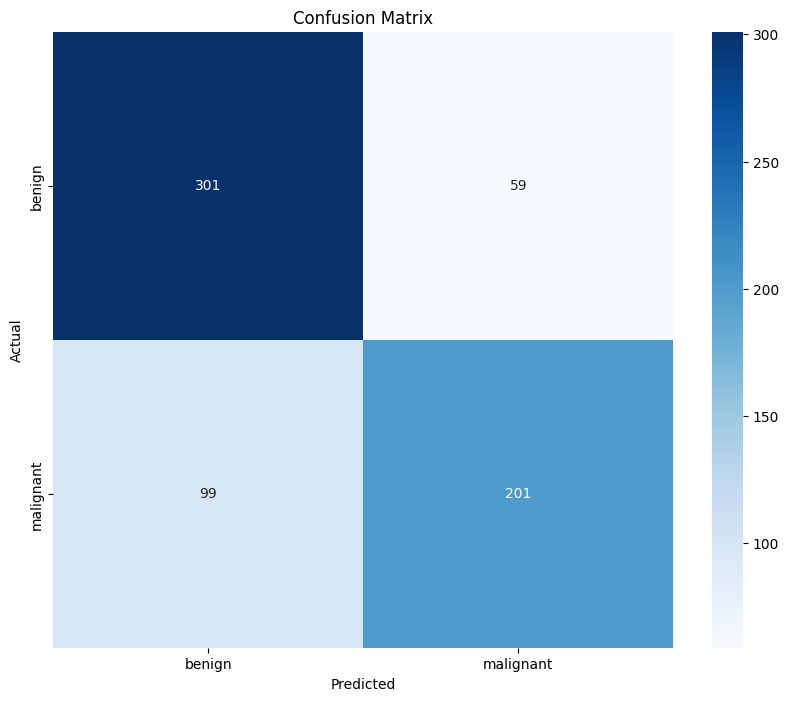

In [8]:
print('...Validating Model...')
all_labels = []
all_predictions = []
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in dataloaders['val']:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)  # Move images and labels to GPU and reshape labels
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold at 0.5
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for confusion matrix
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU for confusion matrix

accuracy = correct / total
print(f'Validation Accuracy: {accuracy}')

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()